Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Schedule Azure Machine Learning Pipelines

In this tutorial, you will learn how to schedule Azure Machine Learning pipelines. The example does a simple data-preparation task every minute. Raw data are read from a CSV file, normalized, and output to another CSV file for downstream processing.

## Domain

The fake domain of this tutorial relates to the popularity of colors. 

In [186]:
from enum import Enum, unique
import numpy as np

In [187]:
  @unique
class Color(Enum) : 
    Red = 0 
    Orange = 1 
    Yellow = 2
    Green = 3
    Blue = 4
    Indigo = 5
    Violet = 6
    
    @classmethod
    def randn_color(cls) : 
        v = np.random.randn()
        c = next((c for c in Color if v < (float(c.value) - 2.5)), Color.Violet)
        return c

Verify that our method `randn_color()` produces a normally-distributed shape:

In [188]:
cs = list(Color.randn_color().value for _ in range(1000))

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  9.,  74., 227., 379., 245.,  62.,   4.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

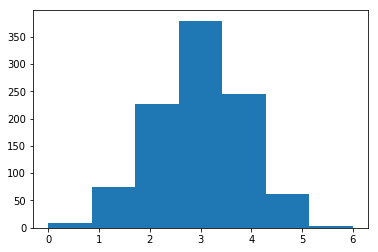

In [190]:
plt.hist(cs,len(Color))

In [191]:
from datetime import datetime,timedelta

In [192]:
def generate_fake_data(minutes, mu, sigma) :
    end_time = datetime.now()
    start_time = end_time - timedelta(minutes=minutes)
    # Generate a random amount of data
    amount_of_fake_data = minutes * int(mu + sigma * np.random.randn())
    # Generate at least 1 element
    amount_of_fake_data = 1 if amount_of_fake_data < 1 else amount_of_fake_data
    arrival_times = np.arange(start_time, end_time, timedelta(minutes = minutes / amount_of_fake_data)).astype(datetime)
    color_votes = list(Color.randn_color().name for _ in range(amount_of_fake_data))
    time_and_vote = zip(arrival_times, color_votes)
    return time_and_vote

`generate_fake_data()` creates a sequence of tuples. Each tuple has an arrival time and a "vote" for a particular color. The arrival times are arrive over the past `minutes`:

In [193]:
list(generate_fake_data(1, 5, 1))

[(datetime.datetime(2019, 9, 30, 15, 15, 25, 324544), 'Green'),
 (datetime.datetime(2019, 9, 30, 15, 15, 35, 324544), 'Blue'),
 (datetime.datetime(2019, 9, 30, 15, 15, 45, 324544), 'Red'),
 (datetime.datetime(2019, 9, 30, 15, 15, 55, 324544), 'Green'),
 (datetime.datetime(2019, 9, 30, 15, 16, 5, 324544), 'Yellow'),
 (datetime.datetime(2019, 9, 30, 15, 16, 15, 324544), 'Orange')]

In [194]:
import os
import csv

In [195]:
def fake_data(storage_dir) : 
    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    # If first time, generate a bit more data 
    minutes_back = 1 if os.path.exists(input_path) else 10 
    data = generate_fake_data(minutes_back, 100, 50)
    with open(input_path, mode='w+') as f : 
        writer = csv.writer(f)
        writer.writerows(data)
    

`fake_data()` creates or appends to the file `unprocessed_data.csv` in `storage_dir`, adding the results of some amount of `generate_fake_data()`. This `unprocessed_data.csv` file stands in for the output of some external datasource (Web site, field data, etc.)

```
2019-09-30 14:10:00.673782,Green
2019-09-30 14:10:01.805857,Yellow
2019-09-30 14:10:02.937932,Indigo
```

## Data Processing

In [196]:
def read_raw_data(storage_dir) : 
    input_data_file = 'unprocessed_data.csv'
    input_path = os.path.join(storage_dir, input_data_file)
    if os.path.exists(input_path) : 
        with open(input_path, mode='r') as f : 
            reader = csv.reader(f)
            return list(reader)
    else :
        # If file doesn't exist, return empty list 
        return []

In [197]:
raw_data = read_raw_data('.')[0:5]
raw_data

[['2019-09-30 14:09:38.032282', 'Green'],
 ['2019-09-30 14:09:39.164357', 'Orange'],
 ['2019-09-30 14:09:40.296432', 'Blue'],
 ['2019-09-30 14:09:41.428507', 'Green'],
 ['2019-09-30 14:09:42.560582', 'Yellow']]

In [198]:
import dateutil

In [199]:
Color['Green']

<Color.Green: 3>

In [200]:
from sklearn.preprocessing import normalize

In [201]:
# Please note: this is just a silly example of converting and normalizing, e.g., "preprocessing stuff"     
def process_raw_data(raw_data) : 
    def convert(d) :
        for datum in d : 
            dt = dateutil.parser.parse(datum[0])
            ts = int(dt.timestamp())
            c = Color[datum[1]].value
            yield (ts, c)
    processed_data = list(convert(raw_data))
    normalized_data = normalize(processed_data, axis = 0)
    return normalized_data

process_raw_data(raw_data)

array([[0.44721359, 0.48038446],
       [0.4472136 , 0.16012815],
       [0.4472136 , 0.64051262],
       [0.4472136 , 0.48038446],
       [0.4472136 , 0.32025631]])

In [202]:
def write_processed_data(storage_dir, processed_data) : 
    output_data_file = 'processed_data.csv'
    output_path = os.path.join(storage_dir, output_data_file)

    # Note: Clobbers existing processed data -- fine in this example
    with open(output_path, mode='w') as f : 
        writer = csv.writer(f)
        writer.writerows(processed_data)

In [232]:
def main() : 
    storage_dir = '.'
    # Write some fake data to 'unprocessed_data.csv' -- normally data would be written via some external process
    fake_data(storage_dir)

    print("Beginning periodic data processing...")
    raw_data = read_raw_data(storage_dir)
    processed_data = process_raw_data(raw_data)
    write_processed_data(storage_dir, processed_data)
    print(f"Wrote {len(processed_data)} records")
    print("...Periodic data processing ended.")

In [233]:
main()

Beginning periodic data processing...
Wrote 107 records
...Periodic data processing ended.
